In [2]:
import pandas as pd

In [3]:
# 检查数据
def check_data(data):
    print("数据的前几行：")
    display(data.head())
    print("\n数据的信息：")
    data.info()
    print("\n数据是否有缺失值：")
    print(data.isnull().sum())
    print("\n数据的描述统计信息：")
    display(data.describe())

file_path = 'SMCI.csv'
data = pd.read_csv(file_path)
check_data(data)

数据的前几行：


,Date,Close/Last,Volume,Open,High,Low
0,06/17/2024,$887.41,8911764,$857.40,$921.91,$828.09
1,06/14/2024,$844.54,6598781,$846.93,$872.00,$825.61
2,06/13/2024,$871.10,11613680,$785.00,$883.17,$784.00
3,06/12/2024,$774.74,4119000,$785.00,$801.3539,$766.16
4,06/11/2024,$767.61,3038731,$780.00,$784.98,$763.085



数据的信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        1259 non-null   object
 1   Close/Last  1259 non-null   object
 2   Volume      1259 non-null   int64 
 3   Open        1259 non-null   object
 4   High        1259 non-null   object
 5   Low         1259 non-null   object
dtypes: int64(1), object(5)
memory usage: 59.1+ KB

数据是否有缺失值：
Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

数据的描述统计信息：


,Volume
count,1.259000e+03
mean,1.571929e+06
std,3.098942e+06
min,3.038000e+03
25%,1.888370e+05
50%,3.717840e+05
75%,1.544620e+06
max,3.403834e+07


In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt

In [5]:
# 目前用的是tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [13]:
# 去除美元符号并转换为浮点数
data['Close'] = data['Close/Last'].str.replace('$', '').astype(float)

In [14]:
data

,Date,Close/Last,Volume,Open,High,Low,Close
0,06/17/2024,$887.41,8911764,$857.40,$921.91,$828.09,887.41
1,06/14/2024,$844.54,6598781,$846.93,$872.00,$825.61,844.54
2,06/13/2024,$871.10,11613680,$785.00,$883.17,$784.00,871.10
3,06/12/2024,$774.74,4119000,$785.00,$801.3539,$766.16,774.74
4,06/11/2024,$767.61,3038731,$780.00,$784.98,$763.085,767.61
...,...,...,...,...,...,...,...
1254,06/24/2019,$19.40,131291,$19.195,$19.55,$19.195,19.40
1255,06/21/2019,$19.06,92528,$19.01,$19.34,$18.95,19.06
1256,06/20/2019,$19.03,25851,$18.55,$19.10,$18.50,19.03
1257,06/19/2019,$18.70,82376,$18.40,$18.70,$18.15,18.70


In [15]:
# 数据预处理
def preprocess_data(train_set, valid_set):
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # 将训练集和验证集的Close列进行归一化
    train_data = scaler.fit_transform(train_set['Close'].values.reshape(-1, 1))
    valid_data = scaler.transform(valid_set['Close'].values.reshape(-1, 1))
    
    #调参：timesteps = 60
    time_steps = 60
    x_train, y_train = [], []
    for i in range(time_steps, len(train_data)):
        x_train.append(train_data[i-time_steps:i, 0])
        y_train.append(train_data[i, 0])
    
    x_valid, y_valid = [], []
    for i in range(time_steps, len(valid_data)):
        x_valid.append(valid_data[i-time_steps:i, 0])
        y_valid.append(valid_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    x_valid, y_valid = np.array(x_valid), np.array(y_valid)
    x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
    
    return x_train, y_train, x_valid, y_valid, scaler

In [16]:
# 调参：LSTM模型
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(60, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [17]:
# 调参：训练模型
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=25, batch_size=32)

In [18]:
# 预测函数
def make_prediction(model, x_valid, scaler):
    predictions = model.predict(x_valid)
    predictions = scaler.inverse_transform(predictions)
    return predictions

In [22]:
data['Date'] = pd.to_datetime(data['Date'])
train_set = data[(data['Date'] >= '2020-01-01') & (data['Date'] < '2023-01-01')].copy()
vaild_set = data[(data['Date'] >= '2023-01-02') & (data['Date'] < '2024-06-17')].copy()

In [23]:
train_set

,Date,Close/Last,Volume,Open,High,Low,Close
366,2022-12-30,$82.10,639186,$80.53,$82.80,$79.52,82.10
367,2022-12-29,$81.91,864433,$81.79,$83.34,$81.10,81.91
368,2022-12-28,$80.60,899849,$82.35,$84.35,$80.56,80.60
369,2022-12-27,$82.89,790164,$82.51,$83.98,$82.19,82.89
370,2022-12-23,$82.19,966232,$81.95,$82.35,$80.13,82.19
...,...,...,...,...,...,...,...
1117,2020-01-08,$23.07,353705,$23.05,$23.20,$23.00,23.07
1118,2020-01-07,$23.10,38683,$23.01,$23.45,$23.01,23.10
1119,2020-01-06,$23.27,93251,$23.40,$23.50,$23.23,23.27
1120,2020-01-03,$23.44,30248,$23.40,$23.74,$23.40,23.44


In [24]:
# 调用预处理
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, vaild_set)
# 训练模型
model = build_model()
train_model(model, x_train, y_train)
#预测
valid_preds = make_prediction(model, x_valid, scaler)

D:\Users\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0333
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0057
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0026
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0022
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0017
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0018
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0021
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0020
Epoch 9/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0018
Epoch 10/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0021
Epoch 11/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0018
Epoch 12/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0019
Epoch 13/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0017
Epoch 14/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0015
Epoch 15/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0018
Epoc

LSTM RMSE on validation set: 184.2169190102796


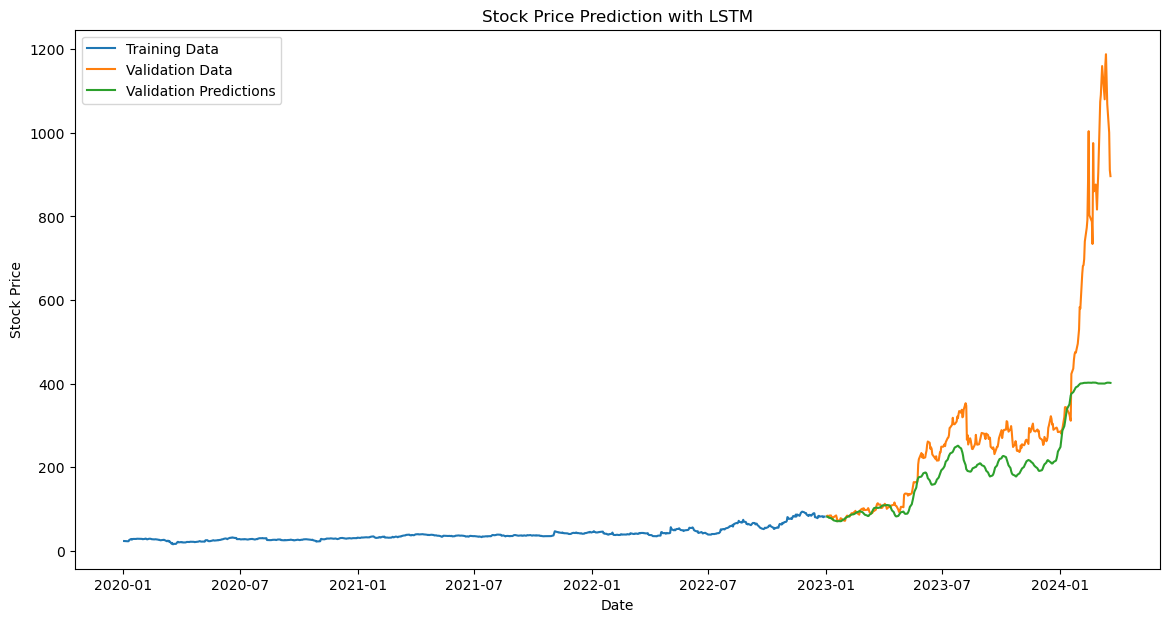

In [25]:
# 计算验证集上的RMSE -- 预测效果非常之差
valid_rmse = np.sqrt(mean_squared_error(vaild_set['Close'].values[60:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# 可视化LSTM结果
plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close'], label='Training Data')
plt.plot(vaild_set['Date'][60:], vaild_set['Close'].values[60:], label='Validation Data')
plt.plot(vaild_set['Date'][60:], valid_preds, label='Validation Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()